# Data Analysis Interview Challenge


### Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

Data description<br>
● city: city this user signed up in<br>
● phone: primary device for this user<br>
● signup_date: date of account registration; in the form ‘YYYYMMDD’<br>
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’<br>
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup<br>
● avg_rating_by_driver: the rider’s average rating over all of their trips<br>
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips<br>
● surge_pct: the percent of trips taken with surge multiplier > 1<br>
● avg_surge: The average surge multiplier over all of this user’s trips<br>
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up<br>
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise<br>
● weekday_pct: the percent of the user’s trips occurring during a weekday<br>


In [1]:
import pandas as pd
import json
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

from sklearn.preprocessing import StandardScaler
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

In [2]:
df_logins = pd.read_json('logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df_logins.describe()

<ipython-input-3-6376fc2a365d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_logins.describe()


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
print("Earliest time in database: ", min(df_logins["login_time"]))
print("Latest time in database: ", max(df_logins["login_time"]), '\n')

print("Total entries: ", len(df_logins))

Earliest time in database:  1970-01-01 20:12:16
Latest time in database:  1970-04-13 18:57:38 

Total entries:  93142


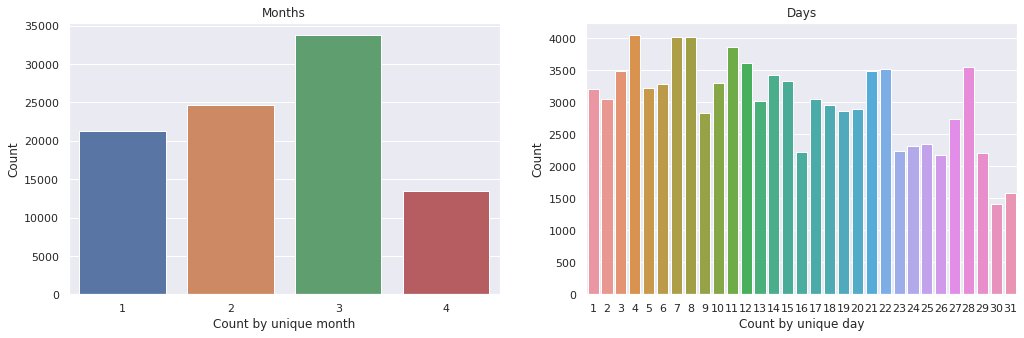

In [6]:
# Set up dataframe

datetimes = list(map(lambda x: x.date(), df_logins['login_time'].tolist())) # extract datetime objects

months = list(map(lambda x: x.month, datetimes)) 
days = list(map(lambda x: x.day, datetimes))

df_datetimes = pd.DataFrame({'month':months, 'day':days}) # Convert to dataframe, with separate month & day columns

# Plot

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
# Count by month
df1 = df_datetimes.groupby('month').count()
sns.barplot(x=df1.index.tolist(), y="day", data=df1, ax=ax1);
ax1.set(xlabel='Count by unique month', ylabel="Count", title="Months");

# Count by day
df2 = df_datetimes.groupby('day').count()
sns.barplot(x=df2.index.tolist(), y="month", data=df2, ax=ax2);
ax2.set(xlabel='Count by unique day', ylabel="Count", title="Days");

March has most number of login and April has the fewest.<br>
Last 2 days of month has the fewest logins


#### Aggregate intervals


In [7]:
df = pd.DataFrame.copy(df_logins) # make copy of dataframe to work with
df.set_index('login_time', inplace=True) # set index to be the timestamps, to allow aggregation
df['count'] = 1 # each timestamp has 1 count
df_15 = df.resample('15T').sum() # aggregate by 15-min intervals
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


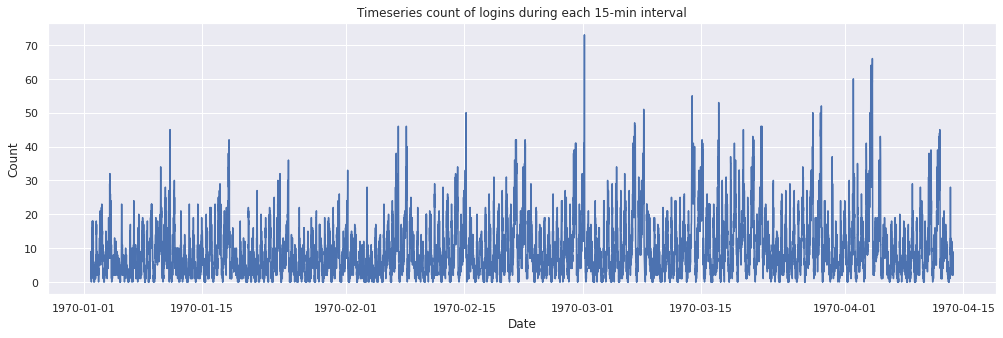

In [8]:
plt.figure(figsize=(17,5));
plt.plot(df_15);
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timeseries count of logins during each 15-min interval');

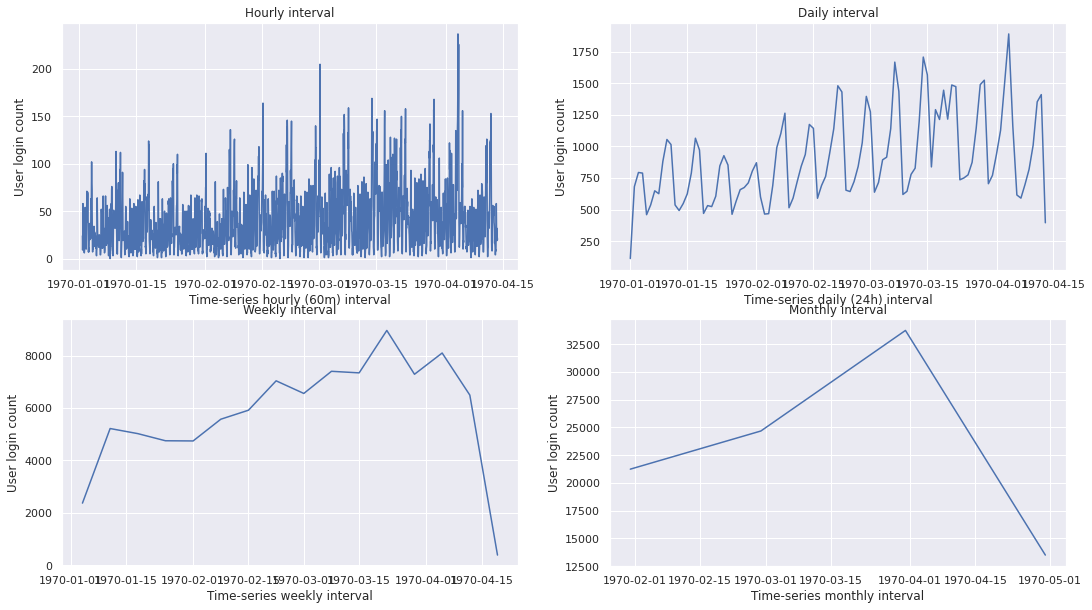

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(df.resample('60T').sum());
ax1.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# Daily interval
ax2.plot(df.resample('D').sum());
ax2.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax3.plot(df.resample('W').sum());
ax3.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax4.plot(df.resample('M').sum());
ax4.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


Determine the change in pre- and post-reimbursement number of times driver has crossed the bridge, since this will indicate whether there is an increase, decrease, or no change in how often driver partners served both cities after the experiment.

A significant post-reimbursement increase in driver crossings supports the experiment's success - driver partners tended to serve both cities more often after the experiment's introduction.

Implementing experiment<br>
Conduct a one-sided, 1-sample z-test, assuming sample size > 30 drivers. Compare number driver bridge crossings (where a crossing = crossing the bridge + serving crossed-to city) pre- and post-reimbursement.<br>

$h_0$: No difference in driver bridge crossings, after toll reimbursement experiment.<br>
$h_a$: Increase in driver bridge crossings, after toll reimbursement experiment.<br>
Null hypothesis distribution is simply the distribution of driver crossings before toll reimbursement experiment.<br>

Calculate z-score of average frequency of drivers serving both cities, post-reimbursement experiment.<br>
Set $a$=0.05. Determine if z-score's p-value falls below this significance threshold.<br>
<br>

Interpreting results<br>
If p-value < 0.05, then the post-reimbursement crossings are so high that it's unlikely to occur under the null hypothesis of pre-reimbursement crossings. This result would support a significant increase in driver bridge crossings after the toll reimbursement is introduced, indicating that this policy was a success.<br>

Caveats & recommendations<br>
However, the caveat is that $a$ significance levels are set arbitrarly and p-values fluctuate depending on sample size. So depending on how wide of a margin the post-reimbursement increase is, our experiment could either support or reject the policy.<br>

As a result, I recommend only considering the policy a success if the margin is wide enough (and p-value far below 0.05) that it is obvious that a significant post-reimbursement increase has occurred even in the midst of the aforementioned fluctuations.<br>

### Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [10]:
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
df= pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [12]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [13]:
# Impute in missing values
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])
df1=df

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


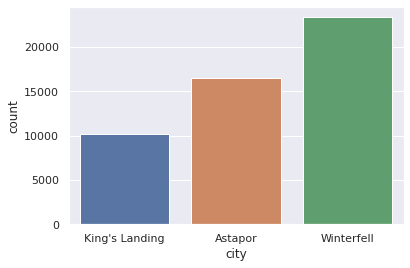

In [15]:
sns.countplot(df.city)
plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


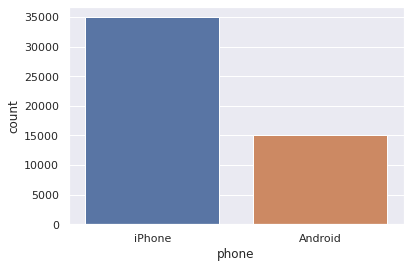

In [16]:
sns.countplot(df.phone)
plt.show()

In [17]:
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [18]:
df.retained=np.nan
df.loc[df['last_trip_date']>='2014-06-01 00:00:00','retained']=1
df.loc[df['last_trip_date']<'2014-06-01 00:00:00','retained']=0
df1=df

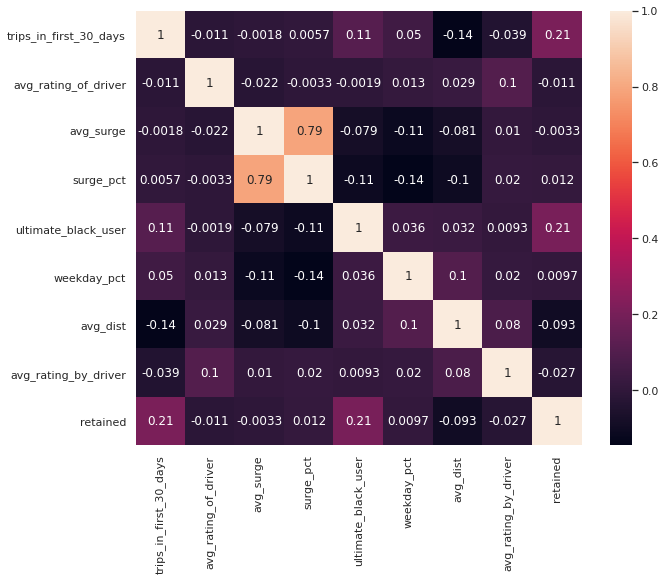

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

The target is related mostly to 'trips_in_first_30_days', and 'ultimate_black_user'.

The target is related mostly to 'trips_in_first_30_days', 'city_King's Landing','phone_iPhone', and 'ultimate_black_user_True'.

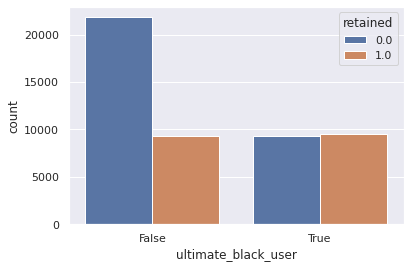

In [20]:
sns.countplot(x='ultimate_black_user', data=df, hue='retained')
plt.show()

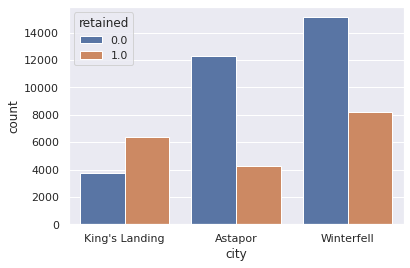

In [21]:
sns.countplot(x='city', data=df, hue='retained')
plt.show()


King's Landing seems to be especially successful in retaining users whereas Astapor is the least successful.

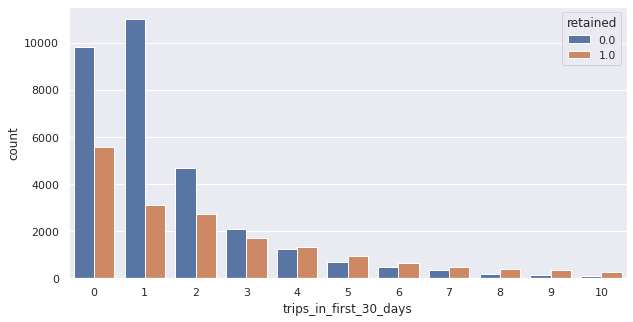

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(x='trips_in_first_30_days', data=df[df['trips_in_first_30_days']<=10],hue='retained')
plt.show()

For number of trips in first 30 days less than 4, people are not retained. However for number of trips in first 30 days more than or equal to 4, people are retained mostly.

### What fraction of the observed users were retained?

In [23]:
print(round(df['retained'].sum()/len(df)*100,3),'% are retained')

37.608 % are retained


### Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

First I change 'city', 'phone'' ultimate_black_user' columns to integer values.

In [24]:
df= pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1.0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0.0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0.0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1.0,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0.0,0,0,1,1,0,1,0


In [25]:
y=df['retained'].values
X=df.drop(['last_trip_date','signup_date','retained'],axis=1)
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=55)

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)

### Classifier

### Gradient Boosting

In [28]:
GradClassifier = GradientBoostingClassifier(n_estimators=200)
GradClassifier.fit(X_train, y_train)
print('Correct accuracy with Gradient Boosting Classifier is:', round(GradClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
GradScores = cross_val_score(GradClassifier, X, y, cv=10)
end=time.time()
print('Gradient boosting score Mean with cross val is:',round(np.mean(GradScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with Gradient Boosting Classifier is: 78.49 %
Gradient boosting score Mean with cross val is: 78.894 %
Total elapsed time is: 95.4618  sec


### AdaBoost

AdaClassifier = AdaBoostClassifier(n_estimators=200)
AdaClassifier.fit(X_train, y_train)
print('Correct accuracy with AdaBoost Classifier is:', round(AdaClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
AdaScores = cross_val_score(AdaClassifier, X, y, cv=10)
end=time.time()
print('Adaboost boosting score Mean with cross val is:',round(np.mean(AdaScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

### Logistic Regression

In [29]:
LogClassifier= LogisticRegression(C=1)
LogClassifier.fit(X_train, y_train)
print('Correct accuracy with Logistic Regression is:', round(LogClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
LogScores = cross_val_score(LogClassifier, X, y, cv=10)
end=time.time()
print('Logistic Regression score Mean with cross val is:',round(np.mean(LogScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with Logistic Regression is: 71.17 %


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Logistic Regression score Mean with cross val is: 71.692 %
Total elapsed time is: 5.7814  sec


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [30]:
RandClassifier= RandomForestClassifier(n_estimators=150)
RandClassifier.fit(X_train, y_train)
print('Correct accuracy with Random Forest Classifier is:', round(RandClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
RandScores = cross_val_score(RandClassifier, X, y, cv=10)
end=time.time()
print('Random Forest score Mean with cross val is:',round(np.mean(RandScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with Random Forest Classifier is: 75.15 %
Random Forest score Mean with cross val is: 75.506 %
Total elapsed time is: 72.0424  sec


### KNN

In [31]:
KnnClassifier=KNeighborsClassifier(n_neighbors=15)
KnnClassifier.fit(X_train, y_train)
print('Correct accuracy with KNN Classifier is:', round(KnnClassifier.score(X_test,y_test)*100,4),'%')

start=time.time()
KnnScores = cross_val_score(KnnClassifier, X, y, cv=10)
end=time.time()
print('KNN score Mean with cross val is:',round(np.mean(KnnScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')

Correct accuracy with KNN Classifier is: 75.45 %
KNN score Mean with cross val is: 76.272 %
Total elapsed time is: 10.0517  sec


We can see GB is giving the best score here

#### Feature importance with GB

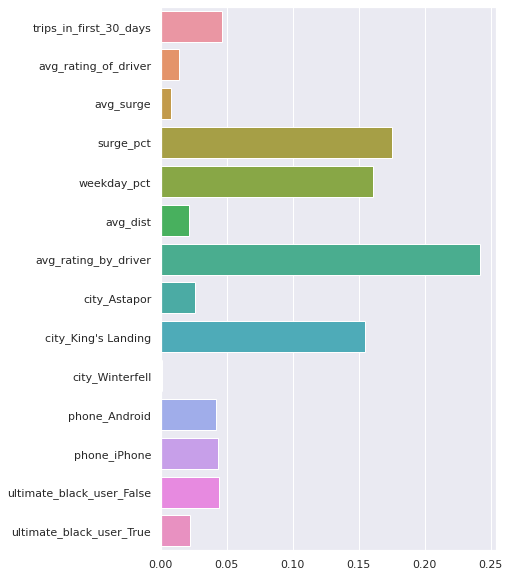

In [32]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=GradClassifier.feature_importances_)
plt.show()

The most important features are "avg_rating_by_driver", "weekday_pct", "surge_pct" and city_king's landing